In [5]:
#Cell 0

import os, sys, math, json, random
from pathlib import Path
import numpy as np
from tqdm import tqdm

# === EDIT THESE THREE ===
KITTI_ROOT   = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")   # not used heavily here
SRC_RUN_DIR  = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\new_outputs\run_7")  # where bev_float & golden already exist
RUN_DIR      = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_halo_2")

FEAT_SRC_DIR = SRC_RUN_DIR/"bev_float"   # expects <fid>.npy with shape (2,H,W): [occ_norm, hag_norm] OR raw
GOLD_SRC_DIR = SRC_RUN_DIR/"golden"      # expects <fid>.npy with shape (H,W) or (1,H,W) 0/1

# New outputs
FEAT3_DIR = RUN_DIR/"feat3"      # 3-ch features we will create
Y_DIR     = RUN_DIR/"y"          # halo labels (binary)
W_DIR     = RUN_DIR/"w"          # per-pixel weight map (float)

for d in [FEAT3_DIR, Y_DIR, W_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Grid/tile/training knobs
HALO_PX       = 2          # dilation (pixels) for halo label (≈0.4–0.6 m depending on BEV resolution)
HALO_W        = 0.5        # weight for halo pixels (inner=1.0, halo=0.5)
OCC_SATURATE  = 1.0        # if your OCC is already [0,1], keep 1.0; else set to 8.0 or so
EDG_Q         = 99.5       # robust normalization for edge magnitude
TILE          = 256        # tile size
POS_MIN_PX    = 32         # min #positive pixels to keep a tile as positive
BG_KEEP_FRAC  = 0.20       # randomly keep this fraction of all-zero tiles
SPLIT_SEED    = 42
SPLIT_FRAC    = (0.9, 0.05, 0.05)  # train/val/test by frame

print("Paths OK")


Paths OK


In [6]:
#Cell 1

import warnings
warnings.filterwarnings("ignore")

# dilation (NumPy)
from scipy.ndimage import binary_dilation

# Sobel edges (OpenCV if present; else SciPy)
try:
    import cv2
    def sobel_edges(img_f32):
        gx = cv2.Sobel(img_f32, cv2.CV_32F, 1, 0, ksize=3)
        gy = cv2.Sobel(img_f32, cv2.CV_32F, 0, 1, ksize=3)
        mag = np.sqrt(gx*gx + gy*gy)
        return mag
except Exception:
    from scipy.ndimage import sobel
    def sobel_edges(img_f32):
        gx = sobel(img_f32, axis=1)
        gy = sobel(img_f32, axis=0)
        mag = np.sqrt(gx*gx + gy*gy)
        return mag

def load_feat2(fid):
    x = np.load(FEAT_SRC_DIR/f"{fid}.npy")
    if x.ndim == 2:  # rare
        x = x[None, ...]
    assert x.shape[0] >= 2, f"need OCC+HAG in {fid}"
    occ = x[0].astype(np.float32)
    hag = x[1].astype(np.float32)
    # Normalize conservatively (if already [0,1], this just clips)
    occ = np.clip(occ / max(OCC_SATURATE, 1e-6), 0, 1).astype(np.float32)
    # HAG: clip to [0,1] if already normalized, else map roughly [-2,2]→[0,1]
    if hag.min() < 0 or hag.max() > 1.5:
        hag = np.clip((hag + 2.0)/4.0, 0, 1).astype(np.float32)
    else:
        hag = np.clip(hag, 0, 1).astype(np.float32)
    return occ, hag

def make_edge(occ):
    mag = sobel_edges(occ.astype(np.float32))
    s = np.percentile(mag, EDG_Q) if np.isfinite(mag).all() else 1.0
    s = 1.0 if s <= 0 else s
    e = np.clip(mag / s, 0, 1).astype(np.float32)
    return e

def load_mask(fid):
    g = np.load(GOLD_SRC_DIR/f"{fid}.npy")
    if g.ndim == 3: g = g[0]
    g = (g>0).astype(np.uint8)
    return g

def make_halo_and_weights(core, r=2, halo_w=0.5):
    core = (core>0).astype(np.uint8)
    halo = binary_dilation(core, iterations=int(r)).astype(np.uint8)
    y = halo  # train against halo (1 inside halo)
    w = np.ones_like(y, dtype=np.float32)
    w[(halo==1) & (core==0)] = float(halo_w)  # inner 1.0, halo ring 0.5
    return y.astype(np.uint8), w


In [8]:
# === Cell 2 — robust export from bev_float(+≥2ch) + golden -> feat3 / y / w ===
import numpy as np
from tqdm import tqdm

# ensure output dirs exist (from Cell 0)
for d in (FEAT3_DIR, Y_DIR, W_DIR):
    d.mkdir(parents=True, exist_ok=True)

def to_CHW(x: np.ndarray) -> np.ndarray:
    """Return array as (C,H,W). Accepts (C,H,W) or (H,W,C)."""
    assert x.ndim == 3, f"Unexpected bev_float ndim={x.ndim}, shape={x.shape}"
    if x.shape[0] <= 6 and x.shape[0] >= 2:
        return x
    if x.shape[-1] <= 6 and x.shape[-1] >= 2:
        return np.moveaxis(x, -1, 0)
    raise ValueError(f"Can't interpret channel axis for shape {x.shape}")

def pick_occ_hag(X: np.ndarray) -> tuple[np.ndarray,np.ndarray]:
    """
    Heuristic: take channel 0 as OCC, channel 1 as HAG.
    Works for 2ch/3ch/6ch exports from previous runs.
    Normalizes to [0,1] defensively.
    """
    X = to_CHW(X).astype(np.float32)
    C,H,W = X.shape
    if C < 2:
        raise ValueError(f"Need ≥2 channels, got {C} in {X.shape}")
    occ = X[0]
    hag = X[1]

    # Clip occupancy to [0,1] (it usually already is)
    occ = np.clip(occ, 0.0, 1.0)

    # HAG may be already normalized; if not, min-max per-frame (robust percentiles)
    if not (0.0 <= hag.min() and hag.max() <= 1.001):
        lo, hi = np.percentile(hag, 1), np.percentile(hag, 99)
        if hi > lo:
            hag = (hag - lo) / (hi - lo)
        hag = np.clip(hag, 0.0, 1.0)

    return occ, hag

# 1) Collect IDs present in BOTH folders defined in Cell 0
fids_all = sorted([
    p.stem for p in FEAT_SRC_DIR.glob("*.npy")
    if (GOLD_SRC_DIR / f"{p.stem}.npy").exists()
])
print("frames found in bev_float ∩ golden:", len(fids_all))
assert fids_all, "No frames found. Check FEAT_SRC_DIR/GOLD_SRC_DIR paths."

# Optional cap (None = all)
MAX_EXPORT = None
fids = fids_all if MAX_EXPORT is None else fids_all[:MAX_EXPORT]

# 2) Export loop
first_shape_printed = False
for fid in tqdm(fids, desc="export 3ch+halo"):
    Xraw = np.load(FEAT_SRC_DIR / f"{fid}.npy")
    if not first_shape_printed:
        print(f"bev_float[{fid}] shape:", Xraw.shape)
        first_shape_printed = True

    occ, hag = pick_occ_hag(Xraw)
    edge = make_edge(occ)  # from Cell 0
    x3   = np.stack([occ, hag, edge], axis=0).astype(np.float32)  # (3,H,W)

    core = np.load(GOLD_SRC_DIR / f"{fid}.npy").astype(np.uint8)  # (H,W) 0/1
    y, w = make_halo_and_weights(core, r=HALO_PX, halo_w=HALO_W) # from Cell 0

    np.save(FEAT3_DIR / f"{fid}.npy", x3)
    np.save(Y_DIR     / f"{fid}.npy", y.astype(np.uint8))
    np.save(W_DIR     / f"{fid}.npy", w.astype(np.float32))

# 3) Quick sanity on one file
fid0 = fids[0]
x0 = np.load(FEAT3_DIR / f"{fid0}.npy")
y0 = np.load(Y_DIR     / f"{fid0}.npy")
w0 = np.load(W_DIR     / f"{fid0}.npy")
print("sample", fid0, "| X3", x0.shape, x0.min(), x0.max(),
      "| Y", y0.shape, int(y0.sum()),
      "| W", float(w0.min()), float(w0.max()))


TypeError: 'type' object is not subscriptable

In [15]:
#Cell 2

# collect frame ids present in both folders
fids = sorted([p.stem for p in FEAT_SRC_DIR.glob("*.npy") if (GOLD_SRC_DIR/f"{p.stem}.npy").exists()])
print("frames found:", len(fids))

# export
for fid in tqdm(fids, desc="export 3ch+halo"):
    occ, hag = load_feat2(fid)
    edge = make_edge(occ)
    x3 = np.stack([occ, hag, edge], axis=0).astype(np.float32)
    ycore = load_mask(fid)
    y, w = make_halo_and_weights(ycore, r=HALO_PX, halo_w=HALO_W)
    np.save(FEAT3_DIR/f"{fid}.npy", x3)
    np.save(Y_DIR/f"{fid}.npy",   y.astype(np.uint8))
    np.save(W_DIR/f"{fid}.npy",   w.astype(np.float32))

# quick sanity on one
if fids:
    fid0 = fids[0]
    x0 = np.load(FEAT3_DIR/f"{fid0}.npy")
    y0 = np.load(Y_DIR/f"{fid0}.npy")
    w0 = np.load(W_DIR/f"{fid0}.npy")
    print("sample", fid0, "| X3", x0.shape, x0.min(), x0.max(), "| Y", y0.shape, y0.sum(), "| W", w0.min(), w0.max())
else:
    print("No frames exported. Re-check SRC paths.")


frames found: 3000


export 3ch+halo: 100%|█████████████████████████████████████████████████████████████| 3000/3000 [03:16<00:00, 15.23it/s]

sample 000000 | X3 (3, 281, 321) 0.0 1.0 | Y (281, 321) 0 | W 1.0 1.0


In [ ]:
# === Cell 3 — make train/val/test over ALL exported frames ===
from pathlib import Path
import random, shutil

DS_DIR = RUN_DIR/"dataset_3ch_halo"
for d in [DS_DIR/"train", DS_DIR/"val", DS_DIR/"test"]:
    d.mkdir(parents=True, exist_ok=True)

# gather frames that actually have x, y, w saved
fids = sorted([
    p.stem for p in FEAT3_DIR.glob("*.npy")
    if (Y_DIR/f"{p.stem}.npy").exists() and (W_DIR/f"{p.stem}.npy").exists()
])
print("total frames available for split:", len(fids))

# ratios (change if you want)
R_TRAIN, R_VAL, R_TEST = 0.80, 0.10, 0.10

# reproducible shuffle
SPLIT_SEED = 42
random.seed(SPLIT_SEED)
random.shuffle(fids)

n = len(fids)
n_train = int(n * R_TRAIN)
n_val   = int(n * R_VAL)
n_test  = n - n_train - n_val

train_ids = fids[:n_train]
val_ids   = fids[n_train:n_train+n_val]
test_ids  = fids[n_train+n_val:]

print(f"split → train:{len(train_ids)}  val:{len(val_ids)}  test:{len(test_ids)}")

def _copy(src: Path, dst: Path):
    # robust on Windows: fall back to copyfile if hardlink not allowed
    try:
        if dst.exists(): dst.unlink()
        os.link(src, dst)
    except Exception:
        shutil.copyfile(src, dst)

def stage(ids, outdir: Path):
    for fid in ids:
        _copy(FEAT3_DIR/f"{fid}.npy", outdir/f"{fid}_x.npy")
        _copy(Y_DIR/f"{fid}.npy",    outdir/f"{fid}_y.npy")
        _copy(W_DIR/f"{fid}.npy",    outdir/f"{fid}_w.npy")

stage(train_ids, DS_DIR/"train")
stage(val_ids,   DS_DIR/"val")
stage(test_ids,  DS_DIR/"test")

print("done staging files into dataset_3ch_halo")

# probe
def probe(root):
    xs = sorted(Path(root).glob("*_x.npy"))
    ys = sorted(Path(root).glob("*_y.npy"))
    ws = sorted(Path(root).glob("*_w.npy"))
    pos, tot = 0, 0
    for yp in ys[:min(400, len(ys))]:
        y = np.load(yp).astype(np.uint8)
        pos += y.sum(); tot += y.size
    pos_pct = 100.0 * pos / max(1, tot)
    x0 = np.load(xs[0]) if xs else None
    print(root.name, "| tiles:", len(xs), "| approx pos%:", f"{pos_pct:.3f}")
    if x0 is not None:
        print("shapes: (x,y,w)", x0.shape, np.load(ys[0]).shape, np.load(ws[0]).shape,
              " | x[min,max]:", float(x0.min()), float(x0.max()))

probe(DS_DIR/"train"); probe(DS_DIR/"val"); probe(DS_DIR/"test")


In [16]:
#Cell 3

DS_DIR = RUN_DIR/"dataset_3ch_halo"
for d in [DS_DIR/"train", DS_DIR/"val", DS_DIR/"test"]:
    d.mkdir(parents=True, exist_ok=True)

random.seed(SPLIT_SEED)
fids_shuf = fids.copy()
random.shuffle(fids_shuf)
n = len(fids_shuf)
n_train = int(n*SPLIT_FRAC[0]); n_val = int(n*SPLIT_FRAC[1])
splits = {
    "train": fids_shuf[:n_train],
    "val":   fids_shuf[n_train:n_train+n_val],
    "test":  fids_shuf[n_train+n_val:],
}
print({k:len(v) for k,v in splits.items()})

def write_tile_set(split, keep_bg_frac=BG_KEEP_FRAC):
    outdir = DS_DIR/split
    kept = 0
    for fid in tqdm(splits[split], desc=f"tiles {split}"):
        X = np.load(FEAT3_DIR/f"{fid}.npy").astype(np.float32)     # (3,H,W)
        Y = np.load(Y_DIR/f"{fid}.npy").astype(np.uint8)           # (H,W)
        Wt= np.load(W_DIR/f"{fid}.npy").astype(np.float32)         # (H,W)
        H,W = Y.shape
        for y0 in range(0, H, TILE):
            for x0 in range(0, W, TILE):
                if y0+TILE>H or x0+TILE>W: 
                    continue
                ytile = Y[y0:y0+TILE, x0:x0+TILE]
                if ytile.sum() >= POS_MIN_PX:
                    xtile = X[:, y0:y0+TILE, x0:x0+TILE]
                    wtile = Wt[y0:y0+TILE, x0:x0+TILE]
                    name = f"{fid}_{y0:04d}_{x0:04d}"
                    np.save(outdir/f"{name}_x.npy", xtile)
                    np.save(outdir/f"{name}_y.npy", ytile)
                    np.save(outdir/f"{name}_w.npy", wtile)
                    kept += 1
                else:
                    if random.random() < keep_bg_frac:
                        xtile = X[:, y0:y0+TILE, x0:x0+TILE]
                        wtile = Wt[y0:y0+TILE, x0:x0+TILE]
                        name = f"{fid}_{y0:04d}_{x0:04d}"
                        np.save(outdir/f"{name}_x.npy", xtile)
                        np.save(outdir/f"{name}_y.npy", ytile)
                        np.save(outdir/f"{name}_w.npy", wtile)
                        kept += 1
    return kept

stats = {}
for sp in ["train","val","test"]:
    stats[sp] = write_tile_set(sp)
print("tile counts:", stats)


{'train': 2700, 'val': 150, 'test': 150}


tiles test: 100%|████████████████████████████████████████████████████████████████████| 150/150 [00:16<00:00,  9.02it/s]

tile counts: {'train': 2493, 'val': 136, 'test': 134}


In [4]:
# Cell 4 — probe dataset folders (train/val/test)
from pathlib import Path
import numpy as np
DS_DIR = RUN_DIR/"dataset_3ch_halo"
def probe(root: Path):
    root = Path(root)
    xs = sorted(root.glob("*_x.npy"))
    ys = [root / (p.stem[:-2] + "_y.npy") for p in xs]
    ws = [root / (p.stem[:-2] + "_w.npy") for p in xs]

    pos, tot = 0, 0
    for yp in ys[:min(1000, len(ys))]:   # sample up to 1000 masks
        y = np.load(yp).astype(np.uint8)
        pos += int(y.sum()); tot += y.size

    approx = 100.0 * pos / max(tot, 1)
    print(f"{root.name:>6} | tiles={len(xs):5d} | approx pos%={approx:6.3f}")

    if xs:
        x = np.load(xs[0]).astype(np.float32)  # (C,H,W)
        y = np.load(ys[0]).astype(np.uint8)    # (H,W)
        w = np.load(ws[0]).astype(np.float32)  # (H,W)
        print("shapes:", x.shape, y.shape, w.shape,
              " | x[min,max]:", float(x.min()), float(x.max()))

# Adjust DS_DIR to your dataset root if needed
probe(DS_DIR / "train")
probe(DS_DIR / "val")
probe(DS_DIR / "test")


 train | tiles= 2493 | approx pos%= 1.629
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0
   val | tiles=  136 | approx pos%= 1.547
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0
  test | tiles=  134 | approx pos%= 1.536
shapes: (3, 256, 256) (256, 256) (256, 256)  | x[min,max]: 0.0 1.0


In [5]:
#Cell 5

import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IN_CH  = 3
BASE   = 16

class TinyUNet(nn.Module):
    def __init__(self, in_ch=IN_CH, base=BASE):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base, base, 3, padding=1), nn.ReLU())
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU())
        self.p2 = nn.MaxPool2d(2)
        self.b  = nn.Sequential(nn.Conv2d(base*2, base*4, 3, padding=1), nn.ReLU(),
                                nn.Conv2d(base*4, base*4, 3, padding=1), nn.ReLU())
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.ReLU())
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.ReLU())
        self.out= nn.Conv2d(base, 1, 1)
    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)  # (B,1,H,W)


In [15]:
#Cell 6

BATCH  = 16
EPOCHS = 20
LR     = 1e-3
POS_W  = 20.0         # scales all positive pixels (helps big imbalance)
EVAL_DIL_R = 2        # pixels for dilated-IoU reporting

class NpyTiles(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.xs = sorted(self.root.glob("*_x.npy"))
        self.ys = [self.root/(p.stem[:-2]+"_y.npy") for p in self.xs]
        self.ws = [self.root/(p.stem[:-2]+"_w.npy") for p in self.xs]
        assert len(self.xs)==len(self.ys)==len(self.ws)>0
    def __len__(self): return len(self.xs)
    def __getitem__(self, i):
        x = np.load(self.xs[i]).astype(np.float32)           # (C,H,W)
        y = np.load(self.ys[i]).astype(np.uint8)[None,...]   # (1,H,W)
        w = np.load(self.ws[i]).astype(np.float32)[None,...] # (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y.astype(np.float32)), torch.from_numpy(w)

train_ds = NpyTiles(DS_DIR/"train")
val_ds   = NpyTiles(DS_DIR/"val")

# simple sampler: weight by fraction of positives in tile
def tile_pos_frac(ypath):
    y = np.load(ypath).astype(np.uint8); return y.mean()
weights=[]
for yp in [train_ds.ys[i] for i in range(len(train_ds))]:
    f = tile_pos_frac(yp); weights.append(0.5/max(f,1e-4) if f>0 else 0.5/max(1-f,1e-4))
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=BATCH, sampler=sampler, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)

m = TinyUNet(IN_CH).to(device)
opt = torch.optim.Adam(m.parameters(), lr=LR)
sch = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4)
posw = torch.tensor([POS_W], device=device)

def loss_weighted(logits, y, w):
    # BCE per-pixel, then multiply by per-pixel weight map
    l = F.binary_cross_entropy_with_logits(logits, y, pos_weight=posw, reduction='none')
    return (l * w).mean()

def eval_iou(loader, thr=0.5, dilate_r=0):
    m.eval(); inter=0; union=0
    with torch.no_grad():
        for xb,yb,wb in loader:
            xb,yb = xb.to(device), yb.to(device)
            p = (torch.sigmoid(m(xb)) > thr).float()
            if dilate_r>0:
                yb = F.max_pool2d(yb, kernel_size=2*dilate_r+1, stride=1, padding=dilate_r)
            inter += (p*yb).sum().item()
            union += (p + yb - p*yb).sum().item()
    return 0.0 if union==0 else inter/union

best, best_path = 0.0, RUN_DIR/"tiny_bev_halo.pt"
print(f"tiles: train={len(train_ds)} val={len(val_ds)} in_ch={IN_CH}")

for ep in range(1, EPOCHS+1):
    m.train(); tot=0; n=0
    for xb,yb,wb in train_loader:
        xb,yb,wb = xb.to(device), yb.to(device), wb.to(device)
        logits = m(xb)
        loss = loss_weighted(logits, yb, wb)
        opt.zero_grad(); loss.backward(); opt.step()
        tot += loss.item()*xb.size(0); n += xb.size(0)
    i30 = eval_iou(val_loader, 0.30, dilate_r=EVAL_DIL_R)
    i40 = eval_iou(val_loader, 0.40, dilate_r=EVAL_DIL_R)
    i50 = eval_iou(val_loader, 0.50, dilate_r=EVAL_DIL_R)
    sch.step(1.0 - i50)
    print(f"epoch {ep:02d} | train_loss {tot/n:.4f} | val IoU(d{EVAL_DIL_R}) t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f}")
    if i50 > best:
        best = i50
        torch.save(m.state_dict(), best_path)

print("saved model to:", best_path)


tiles: train=2493 val=136 in_ch=3
epoch 01 | train_loss 0.4192 | val IoU(d2) t0.30:0.076 t0.40:0.004 t0.50:0.000
epoch 02 | train_loss 0.3144 | val IoU(d2) t0.30:0.091 t0.40:0.106 t0.50:0.113
epoch 03 | train_loss 0.2562 | val IoU(d2) t0.30:0.183 t0.40:0.175 t0.50:0.157
epoch 04 | train_loss 0.2217 | val IoU(d2) t0.30:0.178 t0.40:0.205 t0.50:0.225
epoch 05 | train_loss 0.1891 | val IoU(d2) t0.30:0.266 t0.40:0.276 t0.50:0.271
epoch 06 | train_loss 0.1692 | val IoU(d2) t0.30:0.249 t0.40:0.270 t0.50:0.282
epoch 07 | train_loss 0.1760 | val IoU(d2) t0.30:0.318 t0.40:0.329 t0.50:0.326
epoch 08 | train_loss 0.1591 | val IoU(d2) t0.30:0.304 t0.40:0.334 t0.50:0.346
epoch 09 | train_loss 0.1545 | val IoU(d2) t0.30:0.290 t0.40:0.317 t0.50:0.334
epoch 10 | train_loss 0.1393 | val IoU(d2) t0.30:0.356 t0.40:0.372 t0.50:0.378
epoch 11 | train_loss 0.1339 | val IoU(d2) t0.30:0.274 t0.40:0.306 t0.50:0.331
epoch 12 | train_loss 0.1383 | val IoU(d2) t0.30:0.273 t0.40:0.303 t0.50:0.327
epoch 13 | train_l

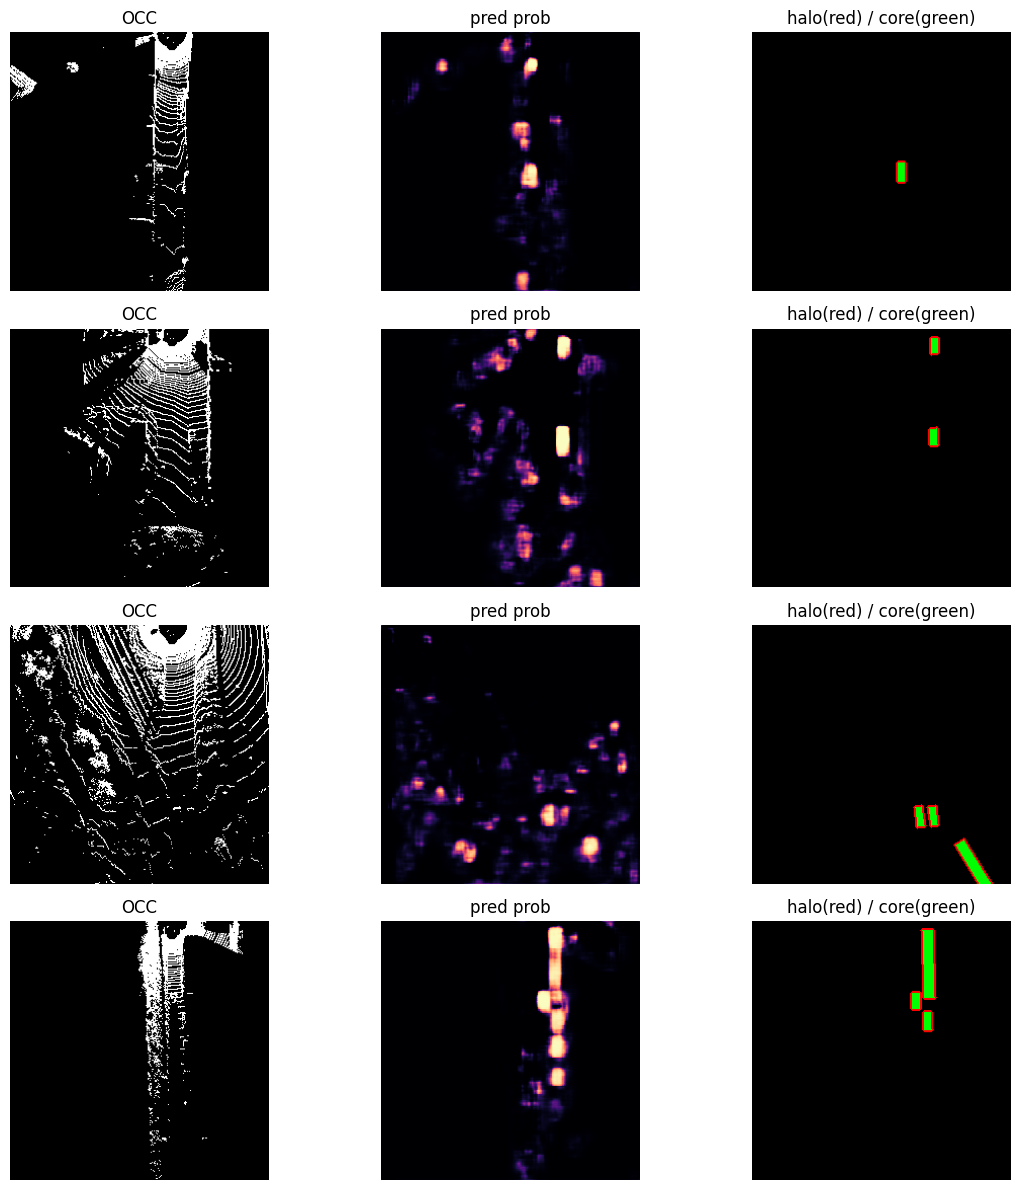

In [16]:
#Cell 7

import matplotlib.pyplot as plt

# pick a few random val tiles
batch = next(iter(val_loader))
xb,yb,wb = [t.to(device) for t in batch]
m.eval()
with torch.no_grad():
    pr = torch.sigmoid(m(xb)).cpu().numpy()

k = min(4, xb.size(0))
plt.figure(figsize=(12, k*3))
for i in range(k):
    occ = xb[i,0].cpu().numpy()
    prb = pr[i,0]
    yy  = yb[i,0].cpu().numpy()
    ww  = wb[i,0].cpu().numpy()
    core = (ww>0.99) & (yy>0)   # inner
    halo = (ww<0.99) & (yy>0)   # halo ring
    plt.subplot(k,3,3*i+1); plt.imshow(occ, cmap='gray'); plt.title("OCC"); plt.axis('off')
    plt.subplot(k,3,3*i+2); plt.imshow(prb, cmap='magma'); plt.title("pred prob"); plt.axis('off')
    mask_vis = np.zeros((*yy.shape,3), np.float32)
    mask_vis[...,0] = halo*1.0  # red=halo
    mask_vis[...,1] = core*1.0  # green=core
    plt.subplot(k,3,3*i+3); plt.imshow(mask_vis); plt.title("halo(red) / core(green)"); plt.axis('off')
plt.tight_layout(); plt.show()


In [18]:
# === Robust EVAL: works with (x,y) or (x,y,w) batches ===
import numpy as np, torch, torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

def pick_xy(batch):
    # batch can be tuple/list (x,y) or (x,y,w) or a dict
    if isinstance(batch, (list, tuple)):
        x = batch[0]; y = batch[1]
    elif isinstance(batch, dict):
        # try common keys
        x = batch.get("x") or batch.get("X")
        y = batch.get("y") or batch.get("Y") or batch.get("mask")
    else:
        raise TypeError(f"Unexpected batch type: {type(batch)}")
    return x, y

# collect probabilities & labels on val set
all_p, all_y = [], []
with torch.no_grad():
    for batch in val_loader:
        xb, yb = pick_xy(batch)
        xb = xb.to(device)
        logits = model(xb)
        all_p.append(torch.sigmoid(logits).cpu().numpy().ravel())
        all_y.append(yb.cpu().numpy().ravel())

p = np.concatenate(all_p).astype(np.float32)
y = np.concatenate(all_y).astype(np.uint8)

# ---- PR / ROC (no sklearn) ----
P = max(1, y.sum()); N = max(1, (y==0).sum())
order = np.argsort(-p)
p_sorted, y_sorted = p[order], y[order]
tp = np.cumsum(y_sorted==1); fp = np.cumsum(y_sorted==0)
rec = tp / P
prec = tp / (tp + fp + 1e-9)
thr  = p_sorted

# PR-AUC
rec_pr  = np.concatenate(([0.0], rec))
prec_pr = np.concatenate(([prec[0]], prec))
auc_pr  = np.trapz(prec_pr, rec_pr)

# ROC-AUC
tpr = tp / P; fpr = fp / N
tpr_roc = np.concatenate(([0.0], tpr, [1.0]))
fpr_roc = np.concatenate(([0.0], fpr, [1.0]))
auc_roc = np.trapz(tpr_roc, fpr_roc)

# Best F1 / IoU threshold
f1 = 2*prec*rec/(prec+rec+1e-9)
k  = int(np.nanargmax(f1))
t_best = float(thr[k]); best_f1 = float(f1[k]); best_iou = float(best_f1/(2-best_f1+1e-9))

def cm_metrics(y, p, t):
    yp = (p >= t).astype(np.uint8)
    tp = int(((yp==1) & (y==1)).sum())
    fp = int(((yp==1) & (y==0)).sum())
    fn = int(((yp==0) & (y==1)).sum())
    tn = int(((yp==0) & (y==0)).sum())
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    iou  = tp/(tp+fp+fn+1e-9); f1 = 2*tp/(2*tp+fp+fn+1e-9)
    acc  = (tp+tn)/len(y)
    return dict(tp=tp, fp=fp, fn=fn, tn=tn, prec=prec, rec=rec, iou=iou, f1=f1, acc=acc)

m_best = cm_metrics(y, p, t_best)

# Optional: threshold for >=80% precision
TARGET_PREC = 0.80
ok = np.where(prec >= TARGET_PREC)[0]
if ok.size:
    j = ok[np.argmax(rec[ok])]
    t_prec = float(thr[j]); m_prec = cm_metrics(y, p, t_prec)
else:
    t_prec = None

print(f"[Val] PR-AUC={auc_pr:.3f} | ROC-AUC={auc_roc:.3f}")
print(f"[Val] Best-IoU thr≈{t_best:.2f}  IoU={m_best['iou']:.3f}  F1={m_best['f1']:.3f}  "
      f"Prec={m_best['prec']:.3f}  Rec={m_best['rec']:.3f}")
if t_prec is not None:
    print(f"[Val] Thr for ≥80% precision ≈ {t_prec:.2f} →", m_prec)
else:
    print("[Val] Could not reach ≥80% precision on this set.")


[Val] PR-AUC=0.685 | ROC-AUC=0.979
[Val] Best-IoU thr≈0.87  IoU=0.475  F1=0.644  Prec=0.663  Rec=0.626
[Val] Thr for ≥80% precision ≈ 0.96 → {'tp': 66529, 'fp': 16628, 'fn': 71366, 'tn': 8758373, 'prec': 0.8000408865158579, 'rec': 0.4824612930127961, 'iou': 0.43054432026300016, 'f1': 0.6019307674212375, 'acc': 0.9901273390826058}
